In [1]:
import pandas as pd
from datetime import timedelta
import numpy as np

from matplotlib import cm
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn import tree
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn import linear_model

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

# Admissions Predictors

In [3]:
aux = pd.read_csv('data.csv',  index_col=0, parse_dates=[0])
df = pd.DataFrame(aux['occupancy'])

In [4]:
df.head()

,occupancy
2014-04-03,8.0
2014-04-04,10.0
2014-04-05,21.0
2014-04-06,26.0
2014-04-07,28.0


## Example of smoothing

In [5]:
p = 30
#df['s_occupancy'] = df['occupancy'].rolling(p, win_type=None).mean()
df['s_occupancy'] = df['occupancy'].ewm(span = p).mean()
df['r_occupancy'] = df['occupancy']-df['s_occupancy']

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

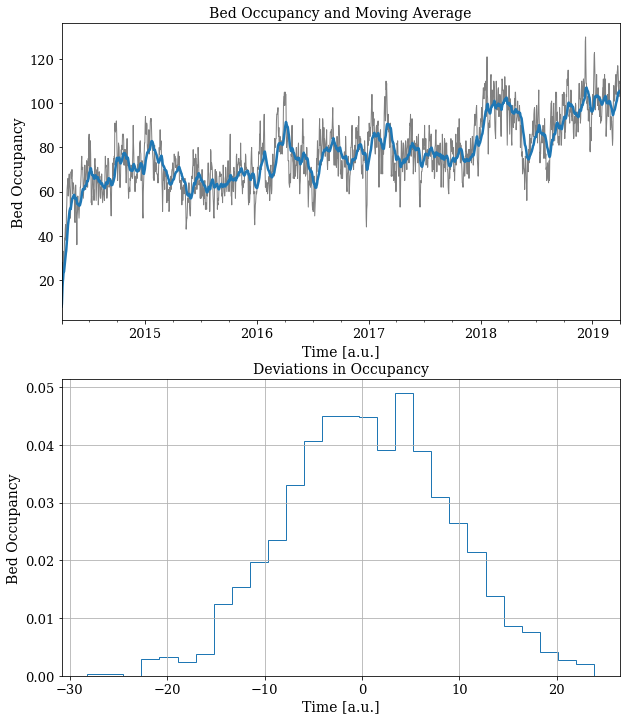

In [6]:
plt.figure(figsize=(10,12))

#y = df['occupancy'].values
#y_s = df['s_occupancy'].values
plt.subplot(2,1,1)
#plt.plot(y[:-p], color='gray', lw=1)
#plt.plot(y_s, color='C0', lw=2.5)
df['occupancy'].plot(color='gray', lw=1)
df['s_occupancy'].plot(color='C0', lw=2.5)

plt.title('Bed Occupancy and Moving Average', fontsize=14)
plt.xlabel('Time [a.u.]', fontsize=14)
plt.ylabel('Bed Occupancy', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.subplot(2,1,2)
df['r_occupancy'].hist(bins='fd',histtype='step', density=1)
#df['r_occupancy'].plot(color='r', lw=1)
plt.title('Deviations in Occupancy', fontsize=14)
plt.xlabel('Time [a.u.]', fontsize=14)
plt.ylabel('Bed Occupancy', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

plt.show()

## The Real Deal

In [7]:
def chrono_split(X,y, f):
    l = len(y)
    X_train = X[0:int(f*l)]
    X_test = X[int(f*l):]
    y_train = y[0:int(f*l)]
    y_test = y[int(f*l):]
    return X_train, X_test, y_train, y_test

In [8]:
def max_error(y_test, y_forecast):
    return  np.max(np.abs(y_test-y_forecast))
def abs_error(y_test, y_forecast):
    return np.mean(np.abs(y_test-y_forecast))
def rsm_error(y_test, y_forecast):
    return np.sqrt(np.sum((y_test-y_forecast)**2))/np.sqrt(len(y_test))

In [9]:
def decomp(df, p):
    df['s_occupancy'] = df['occupancy'].ewm(span = p).mean()
    df['r_occupancy'] = df['occupancy']-df['s_occupancy']
    aux_df = df.dropna()
    return df, aux_df

In [10]:
def inverse_transform(X, y): #acts on arrays, scaler is global function/variable
    aux = np.column_stack((X,y)) 
    aux = scaler.inverse_transform(aux)
    return aux[:,-1]

In [11]:
def transform(df): #acts on dataframes, scaler is global function/variable
    X = df.values
    X = scaler.fit_transform(X)
    return pd.DataFrame(X)

In [12]:
def xy_matrices(df, key,q, l): #standardize x and y and also make the inverse!    
    predictors_dict = {}
    for i in range(len(df)-q):
        predictors_dict[i] = df[key].iloc[i:i+q+l].values #the 1 is actually l
        
    predictors = pd.DataFrame(predictors_dict).T 
    predictors = transform(predictors) 
    
    y = predictors[q].values #here I need l dependence 
    x_predictors = predictors.drop([q], axis=1).values #here too
    
    return x_predictors, y

In [13]:
model_linear = linear_model.LinearRegression()
model_nene = MLPRegressor(activation='relu',solver='lbfgs', alpha=1e-9,
                    hidden_layer_sizes=(350, 350), random_state=0,
                    max_iter=2000,  warm_start=True)
model_tree = tree.DecisionTreeRegressor()
model_gbr = GradientBoostingRegressor(n_estimators=750, learning_rate=0.1,
                                      max_depth=1, random_state=0, loss='ls',
                                      warm_start=True)
model_svr = svm.SVR(gamma='auto')

scaler = StandardScaler()

In [14]:
p = 30 #smoothing
q = 5 #lagging

In [15]:
df, aux_df = decomp(df, p)

In [16]:
models = {'linear':model_linear ,'nene': model_nene, 'tree': model_tree, 
          'gbr': model_gbr, 'svr': model_svr}
errors = {'max':max_error ,'abs': abs_error, 'rsm':rsm_error}

## Smooth

In [17]:
l = 1
f = 0.7
X, y = xy_matrices(aux_df,'s_occupancy' ,q, l)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [18]:
for model in models:
    models[model].fit(X_train, y_train)

/Users/brawantonio/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/base.py:503: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


In [19]:
y_forecast = {} #I can make this chunk a function
error_per_model = {}

y_test_transformed = inverse_transform(X_test, y_test)
for model in models:
    y_forecast[model] = models[model].predict(X_test)
    y_forecast[model] = inverse_transform(X_test, y_forecast[model])
    
    aux_e = np.array([])
    for error in errors:
        aux_error = errors[error](y_test_transformed, y_forecast[model])
        aux_e = np.append(aux_e, aux_error)
    error_per_model[model] = aux_e

error_df = pd.DataFrame(error_per_model)
error_df = error_df.set_index([list(errors.keys())])

In [20]:
cmap = cm.plasma
colors = np.linspace(0,0.75, len(y_forecast))

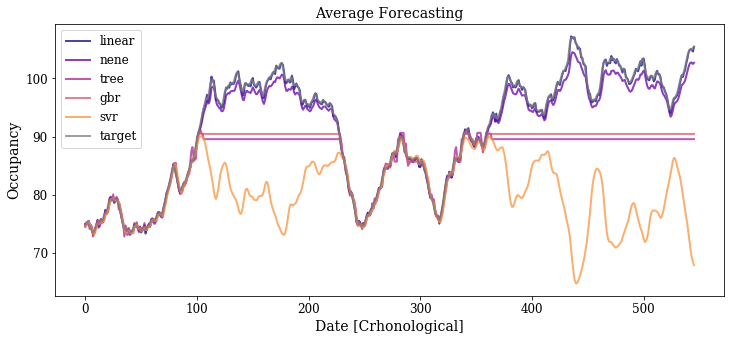

In [21]:
plt.figure(figsize=(12,5))

for model,c in zip(models, colors):    
    plt.plot(y_forecast[model], color=cmap(c), alpha=0.75, lw=2, label='%s'%model)

plt.plot(y_test_transformed, color='gray', alpha=0.75, label='target', lw=2)

plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.title('Average Forecasting', fontsize = 14)
plt.savefig('forecasting.pdf', bbox='tight')
plt.show()

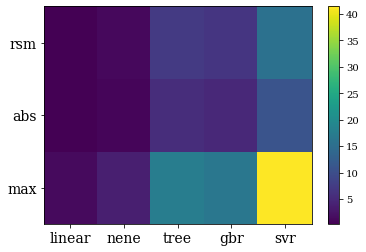

In [22]:
plt.pcolor(error_df)
plt.colorbar()

plt.yticks(np.arange(0.5, len(error_df.index), 1), error_df.index, fontsize=14)
plt.xticks(np.arange(0.5, len(error_df.columns), 1), error_df.columns, fontsize=14)
plt.show()

In [23]:
error_df

,linear,nene,tree,gbr,svr
max,1.302429,3.706289,17.549262,16.654197,41.408711
abs,0.323289,0.955327,5.461322,4.942673,10.964197
rsm,0.392694,1.202868,7.363528,6.730322,15.625675


## Residual

In [24]:
l = 1
f = 0.7
X, y = xy_matrices(aux_df,'r_occupancy' ,q, l)
X_train, X_test, y_train, y_test = chrono_split(X, y, f)

In [25]:
for model in models:
    models[model].fit(X_train, y_train)

In [26]:
y_forecast = {}
error_per_model = {}

y_test_transformed = inverse_transform(X_test, y_test)
for model in models:
    y_forecast[model] = models[model].predict(X_test)
    y_forecast[model] = inverse_transform(X_test, y_forecast[model])

    aux_e = np.array([])
    for error in errors:
        aux_error = errors[error](y_test_transformed, y_forecast[model])
        aux_e = np.append(aux_e, aux_error)
    error_per_model[model] = aux_e

In [27]:
error_df = pd.DataFrame(error_per_model)
error_df = error_df.set_index([list(errors.keys())])

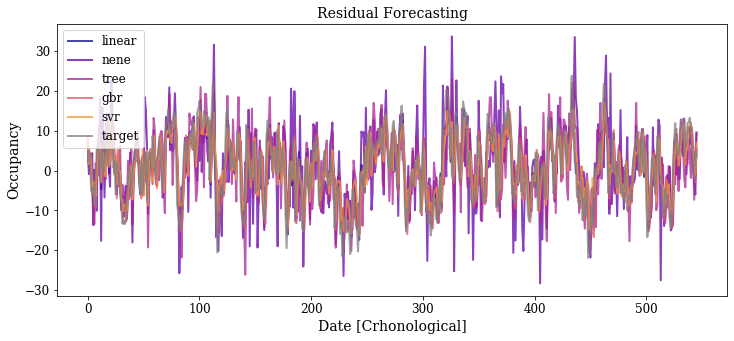

In [28]:
plt.figure(figsize=(12,5))

for model,c in zip(models, colors): 
    plt.plot(y_forecast[model], color=cmap(c), alpha=0.75, lw=2, label='%s'%model)


y_test_transformed = inverse_transform(X_test, y_test)
plt.plot(y_test_transformed, color='gray', alpha=0.75, label='target', lw=2)

plt.ylabel('Occupancy', fontsize=14)
plt.xlabel('Date [Crhonological]', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='best', fontsize=12)
plt.title('Residual Forecasting', fontsize = 14)
plt.savefig('residual_forecasting.pdf', bbox='tight')
plt.show()

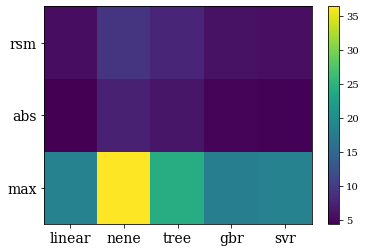

In [29]:
plt.pcolor(error_df)
plt.colorbar()

plt.yticks(np.arange(0.5, len(error_df.index), 1), error_df.index, fontsize=14)
plt.xticks(np.arange(0.5, len(error_df.columns), 1), error_df.columns, fontsize=14)
plt.show()

In [30]:
error_df

,linear,nene,tree,gbr,svr
max,18.494468,36.419883,24.371818,17.944106,18.493761
abs,4.409694,7.318664,6.182113,4.748975,4.558316
rsm,5.436495,9.358280,7.747207,5.842998,5.619547
